# <center> Recommender System </center>

## Preparation

Connect to drive (if needed)

In [6]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.preprocessing import normalize

DRIVE_DIR = ""
USING_DRIVE = False
if USING_DRIVE:
    # from google.colab import drive
    # drive.mount('/content/drive')
    DRIVE_DIR = "drive/My Drive/Bangkit/"

# Check GPU
devices = tf.config.experimental.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


Constants

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

LOG_NAME = "recommender-frelevantprice"
REMARK = "Try current best model with more relevant pricing"
BATCH_SIZE = 1024
LEARNING_RATE = 1e-5
EPOCH = 100
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanSquaredError()

Log dir

In [8]:
DETAIL_DIR = os.path.join(DRIVE_DIR, "log/detail/")
MODEL_DIR = os.path.join(DRIVE_DIR, "log/model/savedmodel/")
KERAS_DIR = os.path.join(DRIVE_DIR, "log/model/keras/")
PLOT_DIR = os.path.join(DRIVE_DIR, "log/plot")
SUMMARY_DIR = os.path.join(DRIVE_DIR, "log/model/summary/")

if (os.path.exists(os.path.join(MODEL_DIR, LOG_NAME)) or 
    os.path.exists(os.path.join(KERAS_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(PLOT_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(SUMMARY_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME))):
    raise FileExistsError


## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [9]:
DATA_DIR = os.path.join(DRIVE_DIR, "data/synt_data_better_price_and_follower/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [10]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
0,1723,6018900,8078640,15046770,"Category 8,Category 2",9.37,0,0,1,1,1
1,82,23809950,35177250,44279670,"Category 4,Category 2,Category 1,Category 8,Ca...",9.26,0,0,1,1,1
2,296,3427860,5198670,5264340,"Category 6,Category 1,Category 4,Category 5",9.25,0,0,1,1,0
3,127,20207160,38229630,74752350,"Category 7,Category 6",9.17,0,0,1,1,1
4,137,4537980,8215080,13298910,"Category 6,Category 1,Category 4,Category 5",9.16,0,0,1,1,1


In [11]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406 entries, 0 to 6405
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6406 non-null   int64  
 1   insta_follower     6406 non-null   int64  
 2   tiktok             6406 non-null   int64  
 3   youtube            6406 non-null   int64  
 4   categories         6406 non-null   object 
 5   avg_rating         6406 non-null   float64
 6   pricing_LOW        6406 non-null   int64  
 7   pricing_BELOW_AVG  6406 non-null   int64  
 8   pricing_AVG        6406 non-null   int64  
 9   pricing_ABOVE_AVG  6406 non-null   int64  
 10  pricing_HIGH       6406 non-null   int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 550.6+ KB


In [12]:
df_influencer.describe()

,id,insta_follower,tiktok,youtube,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
count,6406.000000,6.406000e+03,6.406000e+03,6.406000e+03,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000
mean,3505.326881,9.936103e+05,1.405106e+06,1.952503e+06,6.954530,0.625976,0.716984,0.230097,0.089291,0.063534
std,2153.761090,2.158019e+06,3.200647e+06,4.601825e+06,0.804705,0.483908,0.450499,0.420927,0.285186,0.243940
min,1.000000,1.290000e+03,1.260000e+03,2.490000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1607.250000,6.016500e+04,8.160750e+04,1.084950e+05,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3312.500000,2.187150e+05,2.956500e+05,4.113000e+05,7.010000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5384.750000,8.947575e+05,1.201725e+06,1.692038e+06,7.470000,1.000000,1.000000,0.000000,0.000000,0.000000
max,7387.000000,3.041751e+07,4.039176e+07,7.475235e+07,9.370000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.77
1,1,3,3,0.53
2,1,5,5,0.89
3,1,6,5,0.90
4,1,7,4,0.80


In [14]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413446 entries, 0 to 413445
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            413446 non-null  int64  
 1   inf_id            413446 non-null  int64  
 2   star_rating       413446 non-null  int64  
 3   sentiment_rating  413446 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 12.6 MB


In [15]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,413446.000000,413446.000000,413446.000000,413446.000000
mean,2443.219533,1076.748458,4.141170,0.777486
std,1438.596784,1148.850785,0.789503,0.161847
min,1.000000,1.000000,1.000000,0.000000
25%,1214.000000,260.000000,4.000000,0.680000
50%,2456.000000,639.000000,4.000000,0.790000
75%,3699.000000,1532.000000,5.000000,0.900000
max,5000.000000,7385.000000,5.000000,1.000000


In [16]:
# count = df_history.groupby("inf_id").count()
# inf_with_less_then_10_review = df_history['inf_id'].isin(count[count['own_id'] < 100].index)
# df_history = df_history.drop(df_history[inf_with_less_then_10_review].index)
# df_influencer = df_influencer.drop(df_influencer[inf_with_less_then_10_review].index)

count = df_history.groupby("own_id").count()
own_with_less_then_10_review = df_history['own_id'].isin(count[count['inf_id'] < 10].index)
df_history = df_history.drop(df_history[own_with_less_then_10_review].index)
# df_owner = df_owner.drop(df_owner[own_with_less_then_10_review].index)


In [17]:
df_history

,own_id,inf_id,star_rating,sentiment_rating
8,2,12,5,1.00
9,2,13,4,0.71
10,2,14,4,0.71
11,2,15,4,0.69
12,2,16,4,0.87
...,...,...,...,...
413436,4998,87,5,0.93
413437,4998,543,5,0.95
413438,4998,10,4,0.77
413439,4998,116,5,0.98


## Data Transformation

### Data cleaning

#### Missing value

In [18]:
df_influencer.isnull().sum()

id                   0
insta_follower       0
tiktok               0
youtube              0
categories           0
avg_rating           0
pricing_LOW          0
pricing_BELOW_AVG    0
pricing_AVG          0
pricing_ABOVE_AVG    0
pricing_HIGH         0
dtype: int64

In [19]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [20]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [21]:
def one_hot(df, column):
    one_hot = df[column].str.get_dummies()
    col_name = one_hot.columns
    new_name = list(map(lambda name: column + "_" + name, col_name))
    one_hot.rename(columns={k: v for k, v in zip(col_name, new_name)}, inplace=True)

    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df


In [22]:
YOUTUBE_HIGH_THRES = 2_000_000
YOUTUBE_LOW_THRES = 100_000
TIKTOK_HIGH_THRES = 2_000_000
TIKTOK_LOW_THRES = 100_000
INSTAGRAM_HIGH_THRES = 1_000_000
INSTAGRAM_LOW_THRES = 50_000

# follower_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm['avg_rating'] = df_inf_norm[['avg_rating']] / 10
# df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

# df_inf_norm = one_hot(df_inf_norm, 'price_category') 

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

youtube_bin = [0, YOUTUBE_LOW_THRES, YOUTUBE_HIGH_THRES, df_inf_norm['youtube'].max()]
tiktok_bin = [0, TIKTOK_LOW_THRES, TIKTOK_HIGH_THRES, df_inf_norm['tiktok'].max()]
insta_bin = [0, INSTAGRAM_LOW_THRES, INSTAGRAM_HIGH_THRES, df_inf_norm['insta_follower'].max()]

df_inf_norm['youtube'] = pd.cut(df_inf_norm['youtube'],bins=youtube_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'youtube') 

df_inf_norm['tiktok'] = pd.cut(df_inf_norm['tiktok'],bins=tiktok_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'tiktok') 

df_inf_norm['insta_follower'] = pd.cut(df_inf_norm['insta_follower'],bins=insta_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'insta_follower') 

df_inf_norm.head()

,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1723,0.937,0,0,1,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,82,0.926,0,0,1,1,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
2,296,0.925,0,0,1,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,127,0.917,0,0,1,1,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,137,0.916,0,0,1,1,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0


Combine star and sentiment rating

In [23]:
STAR_WEIGHT = 0.5
SENTIMENT_WEIGHT = 0.5

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
8,2,12,5,1.00,1.000
9,2,13,4,0.71,0.755
10,2,14,4,0.71,0.755
11,2,15,4,0.69,0.745
12,2,16,4,0.87,0.835
...,...,...,...,...,...
413436,4998,87,5,0.93,0.965
413437,4998,543,5,0.95,0.975
413438,4998,10,4,0.77,0.785
413439,4998,116,5,0.98,0.990


In [24]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,2750,2750,2750,2750
2,9193,9193,9193,9193
3,59279,59279,59279,59279
4,196140,196140,196140,196140
5,142165,142165,142165,142165


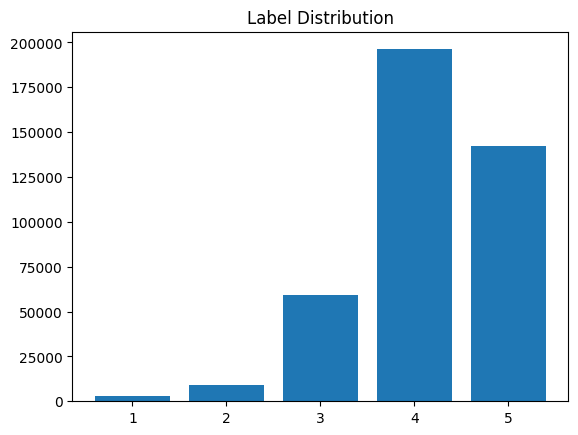

In [25]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [26]:
# df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features = df_inf_features.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features.head()

,own_id,inf_id,combined_rating,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,2,12,1.000,12,0.882,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0
1,2,13,0.755,13,0.781,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0
2,2,14,0.755,14,0.843,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0
3,2,15,0.745,15,0.719,0,0,1,0,0,...,1,1,0,0,1,0,0,1,0,0
4,2,16,0.835,16,0.780,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0


In [27]:
OWNER_FEATURES = df_inf_norm.columns[2:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()
df_own_norm = df_own_norm.drop(['avg_rating'], axis=1)

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Sum those with same owner id, then divide it with sum of all columns for each row
df_own_norm = df_own_norm.groupby('own_id').sum().reset_index()
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].divide(df_own_norm[OWNER_FEATURES].sum(axis=1), axis=0)
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)
df_own_norm

,id,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,2,0.005132,0.010499,0.105600,0.070617,0.060059,0.059266,0.000243,0.070101,0.016030,...,0.002493,0.104074,0.0,0.018365,0.096278,0.0,0.026162,0.104985,0.0,0.017455
1,3,0.000000,0.000000,0.116150,0.086262,0.078532,0.053406,0.000000,0.066804,0.000000,...,0.000000,0.111161,0.0,0.012450,0.108770,0.0,0.014841,0.123611,0.0,0.000000
2,4,0.000000,0.000000,0.104796,0.098095,0.090604,0.086843,0.002430,0.052344,0.004829,...,0.000000,0.104796,0.0,0.000000,0.102475,0.0,0.002322,0.104796,0.0,0.000000
3,5,0.000000,0.002500,0.112650,0.093827,0.078016,0.041609,0.000995,0.072197,0.024252,...,0.007388,0.110521,0.0,0.006514,0.110521,0.0,0.006514,0.114535,0.0,0.002500
4,6,0.000000,0.000000,0.111270,0.099891,0.099891,0.060883,0.000000,0.051310,0.008398,...,0.000000,0.111270,0.0,0.000000,0.111270,0.0,0.000000,0.111270,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,4993,0.008751,0.023072,0.088233,0.058253,0.053378,0.053144,0.000000,0.077363,0.022285,...,0.000000,0.086263,0.0,0.036294,0.085002,0.0,0.037555,0.090359,0.0,0.032198
3748,4994,0.000000,0.001837,0.108375,0.076698,0.065515,0.074374,0.000000,0.058729,0.008809,...,0.000000,0.102852,0.0,0.007360,0.097691,0.0,0.012521,0.108375,0.0,0.001837
3749,4995,0.000000,0.003401,0.108073,0.080238,0.070976,0.060459,0.003401,0.067680,0.000000,...,0.021034,0.104097,0.0,0.012427,0.100042,0.0,0.016482,0.113123,0.0,0.003401
3750,4996,0.000000,0.003170,0.104014,0.088365,0.081681,0.059691,0.002282,0.088122,0.009854,...,0.000000,0.104014,0.0,0.006381,0.096725,0.0,0.013671,0.104014,0.0,0.006381


## Creating Model

Trying to use classical cosine similarity

In [80]:
def calculate_cosine_similarity(user_profile, influencer_data):
    # Calculate cosine similarity using numpy
    ids = influencer_data[:, 0]
    influencer_data = influencer_data[:, 1:] 
    influencer_data = normalize(influencer_data) 
    # user_profile = normalize(user_profile)
    similarity_scores = np.dot(user_profile, influencer_data.T) / (np.linalg.norm(user_profile) * np.linalg.norm(influencer_data, axis=1))

    return ids, similarity_scores

def assign_ratings(similarity_scores, rating_scale):
    # Rank influencers based on similarity scores
    ranked_indices = np.argsort(similarity_scores)[::-1]

    # Assign ratings based on rank
    num_influencers = len(similarity_scores)
    ratings = np.zeros(num_influencers)
    for i, idx in enumerate(ranked_indices):
        rating = rating_scale[i // (num_influencers // len(rating_scale))]
        ratings[idx] = rating

    return ratings

def get_rank_quality(real_rank, predicted_rank):
    from scipy.stats import kendalltau

    corr_score = []
    count = []
    for id, rank in real_rank.iteritems():
        # print(list(rank)[:len(predicted_rank[id])], list(predicted_rank[id]))
        correlation, _ = kendalltau(list(rank), list(predicted_rank[id]))
        corr_score.append(correlation)
        count.append(len(list(rank)))

    df_corr = pd.concat([real_rank, predicted_rank, pd.Series(corr_score, index=real_rank.index), pd.Series(count, index=real_rank.index)], axis=1)
    return df_corr

def ap_at_k(real_rank, predicted_rank, k):
    ap_score = []
    for id, rank in real_rank.iteritems():
        pred = predicted_rank[id]
        relevancy = [int(el in rank[:k]) for el in pred[:k]]
        ap_score.append(sum(elem / (index + 1) for index, elem in enumerate(relevancy)) / len(relevancy))
    
    return np.array(ap_score)

In [81]:
similarity_scores = []
for owner in df_own_norm.to_numpy()[:500]:
    id = int(owner[0])
    owner = owner[1:]
    
    inf_ids, scores = calculate_cosine_similarity(owner, df_inf_norm.drop("avg_rating", axis=1).to_numpy()[:7000])
    own_ids = np.full(len(inf_ids), id)

    similarity_scores.append(np.array(list(zip(own_ids, inf_ids, scores)))) 
    
similarity_scores = [item for sublist in similarity_scores for item in sublist]

In [82]:
# LIMIT = 100
# own_ids = df_own_norm[:LIMIT]['id']
# inf_ids = df_inf_norm[:LIMIT]['id']
# similarity_scores = np.dot(df_own_norm.drop('id', axis=1)[:LIMIT], df_inf_norm.drop(['avg_rating', 'id'], axis=1)[:LIMIT].T)

# # Create a DataFrame from the matrix
# df_matrix = pd.DataFrame(similarity_scores, index=own_ids, columns=inf_ids)

# # Create a new DataFrame to combine the user and movie IDs with the scores
# similarity_scores = pd.DataFrame(columns=['own_id', 'inf_id', 'predicted_score'])

# # Iterate over the matrix and add the user and movie IDs along with the scores to the new DataFrame
# for user_id, row in df_matrix.iterrows():
#     for movie_id, score in row.iteritems():
#         similarity_scores = similarity_scores.append({'own_id': user_id, 'inf_id': movie_id, 'predicted_score': score}, ignore_index=True)

# print(similarity_scores.head())

In [83]:
similarity_scores = pd.DataFrame(similarity_scores, columns=['own_id', 'inf_id', 'predicted_score'])
similarity_scores

,own_id,inf_id,predicted_score
0,2.0,1723.0,0.870951
1,2.0,82.0,0.900550
2,2.0,296.0,0.850434
3,2.0,127.0,0.754390
4,2.0,137.0,0.876479
...,...,...,...
3202995,632.0,4891.0,0.038559
3202996,632.0,6444.0,0.046598
3202997,632.0,7118.0,0.175091
3202998,632.0,6588.0,0.221936


In [84]:
compare = df_history.copy()

compare = compare.merge(similarity_scores, on=['own_id', 'inf_id'])
compare['error'] = abs(compare['combined_rating'] - compare['predicted_score'])
compare

,own_id,inf_id,star_rating,sentiment_rating,combined_rating,predicted_score,error
0,2,12,5,1.00,1.000,0.913243,0.086757
1,2,13,4,0.71,0.755,0.897668,0.142668
2,2,14,4,0.71,0.755,0.932941,0.177941
3,2,15,4,0.69,0.745,0.759443,0.014443
4,2,16,4,0.87,0.835,0.852470,0.017470
...,...,...,...,...,...,...,...
58579,632,307,5,0.97,0.985,0.910555,0.074445
58580,632,2187,5,0.93,0.965,0.772038,0.192962
58581,632,1320,5,0.93,0.965,0.862712,0.102288
58582,632,1623,4,0.69,0.745,0.863755,0.118755


In [85]:
compare['error'].mean()

0.16291936834857138

In [86]:
compare[compare['error'] > 0.1].groupby('own_id').count()

,inf_id,star_rating,sentiment_rating,combined_rating,predicted_score,error
own_id,,,,,,
2,190,190,190,190,190,190
3,14,14,14,14,14,14
4,20,20,20,20,20,20
5,49,49,49,49,49,49
6,4,4,4,4,4,4
...,...,...,...,...,...,...
628,15,15,15,15,15,15
629,37,37,37,37,37,37
630,46,46,46,46,46,46


In [87]:
compare[compare['error'] > 0.5].head()

,own_id,inf_id,star_rating,sentiment_rating,combined_rating,predicted_score,error
10,2,22,5,1.00,1.00,0.320139,0.679861
32,2,44,5,1.00,1.00,0.295186,0.704814
46,2,56,4,0.78,0.79,0.229639,0.560361
62,2,71,5,0.96,0.98,0.420932,0.559068
73,2,81,5,1.00,1.00,0.318622,0.681378


In [88]:
real_rank = compare.groupby('own_id').apply(lambda x: x.sort_values(by='combined_rating', ascending=False)['inf_id'].tolist())
predicted_rank = compare.groupby('own_id').apply(lambda x: x.sort_values(by='predicted_score', ascending=False)['inf_id'].tolist())

In [89]:
ap_at_k(real_rank, predicted_rank, 20).mean()

C:\Users\MAS GAMING\AppData\Local\Temp\ipykernel_7008\700698998.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id, rank in real_rank.iteritems():


0.08531677516622202

In [90]:
df_corr = get_rank_quality(real_rank, predicted_rank)
df_corr

C:\Users\MAS GAMING\AppData\Local\Temp\ipykernel_7008\700698998.py:29: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id, rank in real_rank.iteritems():


,0,1,2,3
own_id,,,,
2,"[12, 125, 156, 152, 145, 140, 139, 137, 133, 1...","[68, 286, 17, 219, 123, 152, 194, 30, 197, 325...",-0.019618,334
3,"[49, 103, 101, 19, 32, 342, 358, 67, 37, 348, ...","[9, 351, 342, 101, 67, 32, 27, 19, 344, 176, 3...",0.105169,34
4,"[102, 159, 361, 80, 24, 6, 82, 376, 363, 62, 4...","[360, 364, 80, 67, 24, 102, 363, 366, 368, 370...",-0.019512,41
5,"[170, 378, 135, 422, 6, 367, 202, 413, 410, 40...","[7, 138, 9, 194, 219, 438, 415, 413, 426, 403,...",0.049540,89
6,"[159, 23, 441, 136, 190, 421, 6, 380, 82, 378,...","[82, 136, 378, 441, 380, 442, 6, 421, 159, 23,...",0.371429,15
...,...,...,...,...
628,"[61, 202, 101, 1616, 376, 1148, 1261, 865, 413...","[1261, 202, 277, 9, 101, 227, 1148, 1158, 246,...",0.066667,36
629,"[173, 545, 194, 1255, 925, 937, 403, 367, 1441...","[1485, 9, 1441, 1426, 427, 1163, 465, 194, 202...",-0.055856,75
630,"[1541, 82, 272, 18, 6, 255, 646, 183, 1426, 7,...","[364, 202, 80, 1877, 305, 9, 19, 27, 18, 227, ...",0.157062,60


In [96]:
from sklearn.neighbors import NearestNeighbors

# Initialize and fit the KNN model
knn_model = NearestNeighbors(n_neighbors=100, metric='cosine')
knn_model.fit(df_inf_norm.drop('avg_rating', axis=1).div(df_inf_norm.drop('avg_rating', axis=1).sum(axis=1), axis=0))

# Find nearest neighbors for the user
distances, indices = knn_model.kneighbors(df_own_norm)

# Get recommended items based on nearest neighbors
# recommended_items = indices.flatten()
# Print the recommended item indices
# print("Recommended Items:", indices)
predicted_rank = pd.Series(indices.tolist(), index=df_own_norm['id'])
ap_at_k(real_rank, predicted_rank, 100).mean()

C:\Users\MAS GAMING\AppData\Local\Temp\ipykernel_7008\700698998.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id, rank in real_rank.iteritems():


0.001158452835538089

In [ ]:
Stopper

In [ ]:
compare.to_csv("compare.csv")

In [ ]:
df_corr[2].mean()

0.008309584375350674

In [ ]:
# from sklearn.

In [ ]:
Stopper

NameError: name 'Stopper' is not defined

# Deep Learning

In [ ]:
def plot_history(history, save=False):
    # Extract the loss, MAE, and MSE values from the history object
    loss = history.history['loss']
    mse = history.history['mse']
    mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mse = history.history['val_mse']
    val_mae = history.history['val_mae']

    # Create a figure and set up the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

    # Plot the loss history
    plt.title(REMARK)
    ax1.plot(loss, label='Loss')
    ax1.plot(val_loss, label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the MSE history
    ax2.plot(mse, label='MSE')
    ax2.plot(val_mse, label='Val MSE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Plot the MAE history
    ax3.plot(mae, label='MAE')
    ax3.plot(val_mae, label='Val MAE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MAE')
    ax3.legend()

    # Show the plot
    plt.tight_layout()
    if (save):
        if (not os.path.exists(os.path.join(PLOT_DIR, LOG_NAME))):
            plt.savefig(os.path.join(PLOT_DIR, LOG_NAME))
    
    plt.show()

In [ ]:
plot_history(history)
plot_history(history, save=True)


NameError: name 'history' is not defined

### Evaluation with test dataset

In [ ]:
test_predict = model.predict(test_dataset)
test_predict

In [ ]:
# Get real label
test_labels = np.array([])
for batch in test_dataset:
    test_labels = np.concatenate([test_labels, batch[1].numpy()])

test_labels

In [ ]:
compare_test = pd.concat([pd.DataFrame(test_predict, columns=["predicted"]), 
                     pd.DataFrame(test_labels, columns=["real"])], axis=1)

compare_test["error"] = abs(compare_test["predicted"] - compare_test["real"])

compare_test

In [ ]:
compare_test[compare_test["error"] >= 1e-1]

In [ ]:
train_predict = model.predict(train_dataset)
train_predict

In [ ]:
# Get real label
train_labels = np.array([])
for batch in train_dataset:
    train_labels = np.concatenate([train_labels, batch[1].numpy()])

train_labels

In [ ]:
compare_train = pd.concat([pd.DataFrame(train_predict, columns=["predicted"]), 
                     pd.DataFrame(train_labels, columns=["real"])], axis=1)

compare_train["error"] = abs(compare_train["predicted"] - compare_train["real"])

compare_train

In [ ]:
compare_train[compare_train["error"] >= 4e-1]

## Logging

In [ ]:
if (not os.path.exists(os.path.join(MODEL_DIR, LOG_NAME))):
    tf.saved_model.save(model, os.path.join(MODEL_DIR, LOG_NAME))

In [ ]:
if (not os.path.exists(os.path.join(KERAS_DIR, LOG_NAME))):
    model.save(os.path.join(KERAS_DIR, LOG_NAME))

In [ ]:
def serialize(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError("Object of type {} is not JSON serializable".format(type(obj)))

In [ ]:
import json
from datetime import timedelta

log = {
    "name": LOG_NAME,
    "training_time": str(timedelta(training_time)),
    "remark": REMARK,
    "test_error": compare_test["error"].mean(),
    "results": {
        "last_loss": history.history["loss"][-1],
        "last_mae": history.history["mae"][-1],
        "last_mse": history.history["mse"][-1],
        "last_val_loss": history.history["val_loss"][-1],
        "last_val_mae": history.history["val_mae"][-1],
        "last_val_mse": history.history["val_mse"][-1],
    },
    "hyperparameter": {
        "learning_rate": LEARNING_RATE,
        "epoch": EPOCH,
        "batch_size": BATCH_SIZE,
        "loss_func": tf.keras.losses.serialize(LOSS_FN)["class_name"],
        "optimizer": tf.keras.optimizers.serialize(OPTIMIZER)["class_name"],
    },
    "data_distribution": {
        "positive": POSITIVE_SIZE,
        "negative": NEGATIVE_SIZE,
        "training_pos": TRAIN_POS_SIZE,
        "training_neg": TRAIN_NEG_SIZE,
    },
    "data_example": {
        "influencer": df_influencer.head().to_dict(),
        "owner": df_own_norm.head().to_dict(),
        "history": df_history.head().to_dict(),
    },
    "eval": {
        "loss": history.history["loss"],
        "mae": history.history["mae"],
        "mse": history.history["mse"],
        "val_loss": history.history["val_loss"],
        "val_mae": history.history["val_mae"],
        "val_mse": history.history["val_mse"],
    }
}
if (not os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME + ".json"))):
    with open(os.path.join(DETAIL_DIR, LOG_NAME + '.json'), 'w') as json_file:
        log = json.dumps(log, default=serialize)
        json_file.write(log)

In [ ]:
summary = model.summary()

In [ ]:
from contextlib import redirect_stdout

with open(os.path.join(SUMMARY_DIR, LOG_NAME + ".txt"), 'w') as f:
    with redirect_stdout(f):
        print("Influencer Model:")
        model_influencer.summary()
        
        print("\nOwner Model:")
        model_owner.summary()
        
        print("\nFull Model:")
        model.summary()